# Creating Binary Cassification NN Model

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import pandas as pd
from matplotlib import pyplot as plt

### Split the Train/Test set (80% Train, 20% Test)

In [7]:
# Split the train and test data
df = pd.read_csv("../datasets/binarydataset.csv",index_col=0)
X = df.iloc[:, 1:]  # Returns Features
Y = df.iloc[:, 0]  # Returns Calls
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=True)  # Select different data

### Create Binary Classification Model (Sequential)
Layers:
1. Flatten 18 features to input data
2. Hidden layer between 20 - 320 neurons w/ ReLu activation  
3. Output layer w/ Sigmoid activation

Hyperparameters being tuned
1. Amount of neurons in first layer w/ 40 steps 
2. Learning Rate [1e-1, le-4]

In [4]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(18,)))  # Input Layer (18=features)
    model.add(Dense(units=hp.Int("units", min_value=20, max_value=320, step=40),
              activation="relu", name="Hidden_layer1"))  # Find best amount of neurons for layer
    model.add(Dense(1, activation="sigmoid", name="Output_layer"))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[
                  1e-2, 1e-4])), loss='binary_crossentropy', metrics=["accuracy"])  # Adam = SGD
    return model


## Create deep neural network model with 1-5 layers
NOTE: Not used within tuning/training since accuracy doesn't improve

In [ ]:
def build_model_layerN(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(10,)))  # Input Layer (10=features)

    # Finds how many layers should be in NN
    for layer in range(hp.Int("num_layers", 1, 5)):
        model.add(Dense(units=hp.Int("units_" + str(layer), min_value=20, max_value=320,
                  step=40), activation="relu"))  # Find best amount of neurons for layer
    model.add(Dense(1, activation="sigmoid", name="output_layer"))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[
                  1e-2, 1e-4])), loss='binary_crossentropy', metrics=["accuracy"])  # Adam = SGD
    return model

### Find the best hyperparameters for TrainingSet using RandomSearch
How to determine max_trails and executions_per_trail https://medium.com/@avengers14.blogger/what-are-max-trials-and-executions-per-trial-in-keras-tuner-68ef9a18497d

In [5]:
# Stop training when loss doesn't imporve in 5 epoches
callback = EarlyStopping(monitor="loss", min_delta=.01, patience=3)
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    directory='trails_directory',  # Store results
    project_name='FirePredict',
    overwrite=True, 
    max_trials=32,  # Bc 16 steps x 2 learning_rates
    executions_per_trial=3  # How many times to train verison of model
)

Trial 12 Complete [00h 00m 09s]
val_accuracy: 0.9357773065567017

Best val_accuracy So Far: 0.9370635747909546
Total elapsed time: 00h 01m 49s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_n_layers = RandomSearch(
    build_model_layerN,
    objective='val_accuracy',
    directory='trails_directory_V2',  # Store results
    project_name='FirePredict',
    overwrite=True, # Delete Previous Trails Files
    max_trials=160,  # Bc 16 steps x 2 learning_rates x 5 potential layers
    executions_per_trial=3  # How many times to train verison of model
)

tuner.search(X_train, Y_train, callbacks=[callback], validation_split=.5, shuffle = True)

## Obtain the best hyperparameters to be used within training of model

In [45]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
# accuracy = train accuracy, val_accuracy = test accuracy
history = model.fit(X_train, Y_train, epochs=50, callbacks=[callback], validation_split=.5, shuffle=True)

Epoch 1/50
114/114 [==============================] - 2s 9ms/step - loss: 0.5440 - accuracy: 0.8098 - val_loss: 0.2235 - val_accuracy: 0.9457
Epoch 2/50
114/114 [==============================] - 1s 7ms/step - loss: 0.2152 - accuracy: 0.9358 - val_loss: 0.2417 - val_accuracy: 0.9438
Epoch 3/50
114/114 [==============================] - 1s 7ms/step - loss: 0.2313 - accuracy: 0.9286 - val_loss: 0.4351 - val_accuracy: 0.9363
Epoch 4/50
114/114 [==============================] - 1s 7ms/step - loss: 0.2770 - accuracy: 0.9159 - val_loss: 0.1934 - val_accuracy: 0.9454
Epoch 5/50
114/114 [==============================] - 1s 7ms/step - loss: 0.2017 - accuracy: 0.9407 - val_loss: 0.1851 - val_accuracy: 0.9457
Epoch 6/50
114/114 [==============================] - 1s 8ms/step - loss: 0.2028 - accuracy: 0.9388 - val_loss: 0.1901 - val_accuracy: 0.9457
Epoch 7/50
114/114 [==============================] - 1s 7ms/step - loss: 0.2240 - accuracy: 0.9322 - val_loss: 0.1835 - val_accuracy: 0.9457
Epoch 

# Stats about Neural Network Model

Training and Validation set accuracy

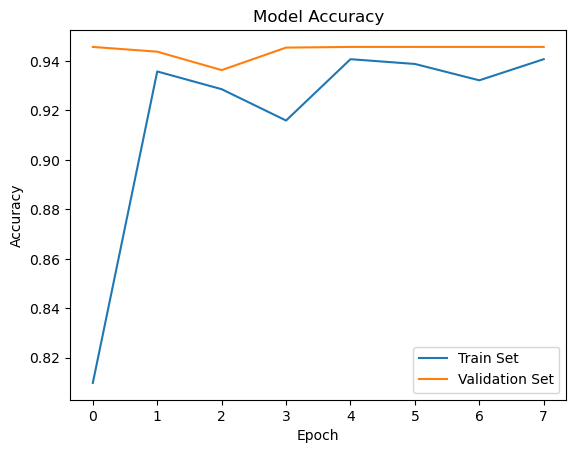

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 18)                0         
                                                                 
 Hidden_layer1 (Dense)       (None, 220)               4180      
                                                                 
 Output_layer (Dense)        (None, 1)                 221       
                                                                 
Total params: 4,401
Trainable params: 4,401
Non-trainable params: 0
_________________________________________________________________


In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Set", "Validation Set"], loc="lower right")
plt.show()
model.summary()

Training and Validation Loss

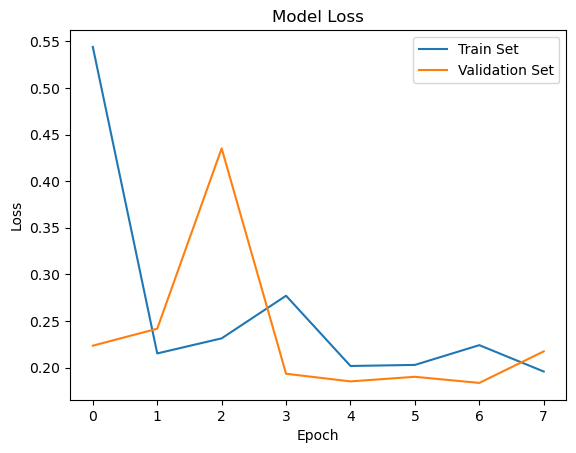

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Validation Set'], loc='upper right')
plt.show()

## Questions/Concerns
Since Validation > Train, could there be a form of bias within the data? Would I need to increase the training set within validation_split? Possibly not much variance going on in the features?

Does having a "small" dataset make it more of a subject to low variance leading to high bias? Would K-fold cross-validation make sense?

In [49]:
loss, accuracy = model.evaluate(X_test,Y_test)

57/57 [==============================] - 0s 2ms/step - loss: 0.2893 - accuracy: 0.9261
